In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
from pathlib import Path
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


In [114]:
data_path = Path("mfcc.nosync/")
print(os.listdir(data_path))

['Marathi_Bhavgeet', 'Michael_Jackson', 'Indian_National_Anthem', 'Marathi_Lavani', 'Kishore_Kumar', 'Asha_Bhosle']


In [115]:
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(data_path)

There are 6 directories and 0 images in 'mfcc.nosync'.
There are 0 directories and 47 images in 'mfcc.nosync/Marathi_Bhavgeet'.
There are 0 directories and 87 images in 'mfcc.nosync/Michael_Jackson'.
There are 0 directories and 112 images in 'mfcc.nosync/Indian_National_Anthem'.
There are 0 directories and 51 images in 'mfcc.nosync/Marathi_Lavani'.
There are 0 directories and 90 images in 'mfcc.nosync/Kishore_Kumar'.
There are 0 directories and 96 images in 'mfcc.nosync/Asha_Bhosle'.


In [116]:
img = data_path / "Michael_Jackson" / "(I Can't Make It) Another Day (feat. Lenny Kravitz)_mfcc.csv"
img = pd.read_csv(img)
print(img.shape)
img_np = img.to_numpy()

(23784, 20)


In [117]:
def transform(img, epsilon=1e-8):
    # Convert the input image (Pandas DataFrame) to a torch tensor
    img_tensor = torch.tensor(img.values, dtype=torch.float32)
    
    # Add batch and channel dimensions for the CNN
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)  # Shape becomes [1, 1, H, W]
    
    # Resize the image to the required size (5000, 20)
    img_resized = F.interpolate(img_tensor, size=(5000, 20), mode='bilinear', align_corners=False)
    
    # Normalize each column (feature) individually
    for i in range(img_resized.shape[2]):  # Iterate through the columns (features)
        column = img_resized[:, :, i, :]  # Extract each column
        mean = column.mean()
        std = column.std()
        
        # Prevent division by zero
        std = std + epsilon
        
        # Normalize the column (feature)
        img_resized[:, :, i, :] = (column - mean) / std
    
    return img_resized

In [118]:
tranformed_img = transform(img)
print(tranformed_img.shape)

torch.Size([1, 1, 5000, 20])


Text(0.5, 1.0, 'Transformed Image')

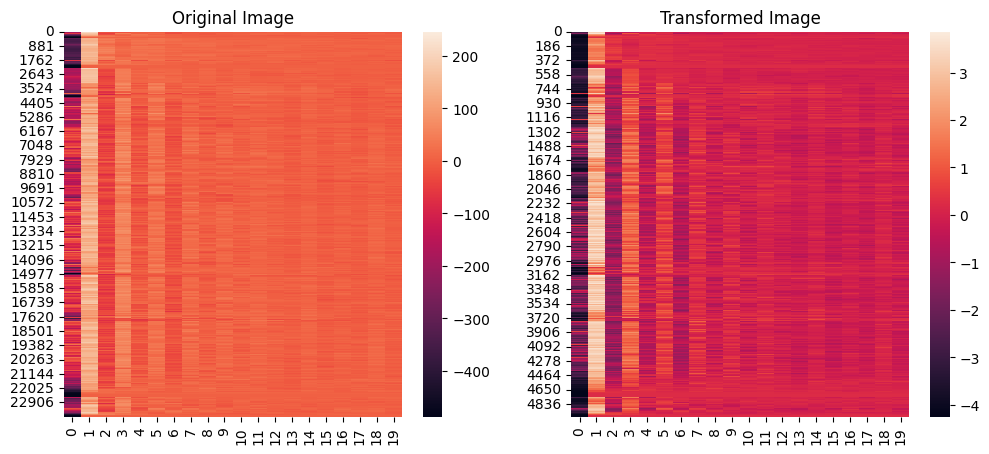

In [119]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(img_np)
plt.title("Original Image")

plt.subplot(1, 2, 2)
sns.heatmap(tranformed_img[0, 0, :, :].numpy())
plt.title("Transformed Image")

In [120]:
def convert_data(song_path):
    img = pd.read_csv(song_path)
    tranformed_img = transform(img)
    return tranformed_img

In [121]:
X = []
y = []
artists = ['Asha_Bhosle', 'Michael_Jackson', 'Kishore_Kumar', 'Indian_National_Anthem', 'Marathi_Bhavgeet', 'Marathi_Lavani']
artist_paths = [path for path in data_path.iterdir() if path.is_dir()]
print(artist_paths)

for artist_path in artist_paths:
    artist = artist_path.name
    print(f"Processing artist: {artist}")
    
    for song_path in tqdm(artist_path.glob('*.csv')):  # No need for `iterdir()` here
        try:
            # Assuming convert_data is a function that processes each song_path file
            X.append(convert_data(song_path))
            y.append(artists.index(artist))
        except Exception as e:
            print(f"Error processing {song_path}: {e}. Skipping this file.")

print(f"Total samples collected: {len(X)}, labels: {len(y)}")


[PosixPath('mfcc.nosync/Marathi_Bhavgeet'), PosixPath('mfcc.nosync/Michael_Jackson'), PosixPath('mfcc.nosync/Indian_National_Anthem'), PosixPath('mfcc.nosync/Marathi_Lavani'), PosixPath('mfcc.nosync/Kishore_Kumar'), PosixPath('mfcc.nosync/Asha_Bhosle')]
Processing artist: Marathi_Bhavgeet


47it [00:34,  1.36it/s]


Processing artist: Michael_Jackson


61it [00:39,  1.48it/s]

Error processing mfcc.nosync/Michael_Jackson/Voice-Over Intro Quincy Jones Interview #2_mfcc.csv: No columns to parse from file. Skipping this file.


81it [00:53,  1.27it/s]

Error processing mfcc.nosync/Michael_Jackson/Voice-Over Intro Quincy Jones Interview #1 _mfcc.csv: No columns to parse from file. Skipping this file.


87it [00:57,  1.52it/s]


Processing artist: Indian_National_Anthem


112it [01:19,  1.41it/s]


Processing artist: Marathi_Lavani


51it [00:39,  1.29it/s]


Processing artist: Kishore_Kumar


5it [00:04,  1.10it/s]

Error processing mfcc.nosync/Kishore_Kumar/Zindagi Milke Bitayenge - Happy Version _mfcc.csv: No columns to parse from file. Skipping this file.


8it [00:06,  1.43it/s]

Error processing mfcc.nosync/Kishore_Kumar/Mere Deshpremiyo - Desh Premee _mfcc.csv: No columns to parse from file. Skipping this file.


42it [00:28,  1.39it/s]

Error processing mfcc.nosync/Kishore_Kumar/Jawani Ki Rail Kahin Choot Na Jaye - Coolie _mfcc.csv: No columns to parse from file. Skipping this file.


66it [00:44,  1.49it/s]

Error processing mfcc.nosync/Kishore_Kumar/Mubarak Ho Tum Sabko Haj Ka Mahina - Coolie _mfcc.csv: No columns to parse from file. Skipping this file.


70it [00:46,  1.81it/s]

Error processing mfcc.nosync/Kishore_Kumar/Yeh Dosti Hum Nahin - Happy Version _mfcc.csv: No columns to parse from file. Skipping this file.


87it [00:58,  1.23it/s]

Error processing mfcc.nosync/Kishore_Kumar/Dariya Mein Jahaz Chale - Shaan _mfcc.csv: No columns to parse from file. Skipping this file.


90it [01:00,  1.49it/s]


Processing artist: Asha_Bhosle


11it [00:07,  1.68it/s]

Error processing mfcc.nosync/Asha_Bhosle/Zindagi Milke Bitayenge - Happy Version _mfcc.csv: No columns to parse from file. Skipping this file.


15it [00:09,  1.99it/s]

Error processing mfcc.nosync/Asha_Bhosle/Mere Deshpremiyo - Desh Premee _mfcc.csv: No columns to parse from file. Skipping this file.


49it [00:28,  1.71it/s]

Error processing mfcc.nosync/Asha_Bhosle/Jawani Ki Rail Kahin Choot Na Jaye - Coolie _mfcc.csv: No columns to parse from file. Skipping this file.


77it [00:45,  1.57it/s]

Error processing mfcc.nosync/Asha_Bhosle/Mubarak Ho Tum Sabko Haj Ka Mahina - Coolie _mfcc.csv: No columns to parse from file. Skipping this file.


80it [00:46,  2.17it/s]

Error processing mfcc.nosync/Asha_Bhosle/Yeh Dosti Hum Nahin - Happy Version _mfcc.csv: No columns to parse from file. Skipping this file.


92it [00:52,  1.63it/s]

Error processing mfcc.nosync/Asha_Bhosle/Dariya Mein Jahaz Chale - Shaan _mfcc.csv: No columns to parse from file. Skipping this file.


96it [00:54,  1.77it/s]

Total samples collected: 469, labels: 469


In [122]:
num_classes = len(artists)
print(num_classes)

6


In [123]:
X = torch.stack(X)


In [124]:
X_sq = X.squeeze(1)
print(X_sq.shape)

torch.Size([469, 1, 5000, 20])


In [125]:
y_t = torch.tensor(y)
print(y_t.shape)

torch.Size([469])


In [126]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sq, y_t, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([375, 1, 5000, 20]) torch.Size([375]) torch.Size([94, 1, 5000, 20]) torch.Size([94])


In [127]:

# # Select the first 40 elements from X_test and y_test (assuming these are the 30% sample)
# X_test_sample = X_test[:40]
# y_test_sample = y_test[:40]

# # Concatenate X_test_sample and y_test_sample to X_train and y_train
# X_test_extended = np.concatenate([X_test, X_test_sample], axis=0)
# y_test_extended = np.concatenate([y_test, y_test_sample], axis=0)

# X_test = torch.tensor(X_test_extended)
# y_test = torch.tensor(y_test_extended)
# print(X_test.shape, y_test.shape)

In [128]:
from torch.utils.data import Dataset

class MusicDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = MusicDataset(X_train, y_train)
test_dataset = MusicDataset(X_test, y_test)

len(train_dataset), len(test_dataset)

(375, 94)

In [129]:
from torch.utils.data import DataLoader
BATCH_SIZE = 4
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=0)  # Disable multi-threaded loading

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0)  # Disable multi-threaded loading


train_dataloader, test_dataloader, len(train_dataloader), len(test_dataloader)


(<torch.utils.data.dataloader.DataLoader at 0x16e256d80>,
 94,
 24)

In [130]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, input_channels: int = 1, output_shape: int = num_classes):
        super(SimpleCNN, self).__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(0.3)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(0.3)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(0.3)
        )
        
        self._dummy_input = torch.zeros(1, input_channels, 20, 5000)
        self._conv_out_size = self._get_conv_output(self._dummy_input)
        print("Calculated output size after conv layers:", self._conv_out_size)
        
        self.fc1 = nn.Linear(self._conv_out_size, 512)
        self.fc2 = nn.Linear(512, output_shape)

    def _get_conv_output(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        return int(torch.prod(torch.tensor(x.size()[1:])))  # Flatten the dimensions

    def forward(self, x, extract_features=False):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        
        x = x.view(x.size(0), -1)
        
        if extract_features:
            features = self.fc1(x)
            return features
        
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [131]:
# Example usage with a random input
x = torch.randn(2, 1, 5000, 20)  # Simulating a batch of 28x28 grayscale images (e.g., MNIST)

# Create and test the model
model = SimpleCNN(input_channels=1, output_shape=num_classes)

model.eval()
with torch.no_grad():
    output = model(x)

print("Output shape:", output.shape)  # Should print torch.Size([2, 10])
print(output)

Calculated output size after conv layers: 160000
Output shape: torch.Size([2, 6])
tensor([[-0.0256,  0.0076,  0.0614, -0.0763, -0.0697,  0.0167],
        [-0.0391, -0.0189,  0.0324, -0.1029, -0.0866,  0.0307]])


In [132]:
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()

In [146]:
from torchsummary import summary
summary(model, (1, 5000, 20))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 5000, 20]             320
              ReLU-2         [-1, 32, 5000, 20]               0
         MaxPool2d-3         [-1, 32, 2500, 10]               0
           Dropout-4         [-1, 32, 2500, 10]               0
            Conv2d-5         [-1, 64, 2500, 10]          18,496
              ReLU-6         [-1, 64, 2500, 10]               0
         MaxPool2d-7          [-1, 64, 1250, 5]               0
           Dropout-8          [-1, 64, 1250, 5]               0
            Conv2d-9         [-1, 128, 1250, 5]          73,856
             ReLU-10         [-1, 128, 1250, 5]               0
        MaxPool2d-11          [-1, 128, 625, 2]               0
          Dropout-12          [-1, 128, 625, 2]               0
           Linear-13                  [-1, 512]      81,920,512
           Linear-14                   

In [133]:
from train_utils import train_step, test_step, train

model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=5, device=device)

Epoch: 0 | Train loss: 4.1993 | Train acc: 0.2323 | Test loss: 1.786311 | Test acc: 0.2083
Epoch: 1 | Train loss: 1.7437 | Train acc: 0.2553 | Test loss: 1.679188 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.5822 | Train acc: 0.3209 | Test loss: 1.621248 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.4392 | Train acc: 0.4211 | Test loss: 1.612250 | Test acc: 0.4167
Epoch: 4 | Train loss: 1.3762 | Train acc: 0.4344 | Test loss: 1.509551 | Test acc: 0.3646


In [134]:
model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=3, device=device)

Epoch: 0 | Train loss: 1.2407 | Train acc: 0.5443 | Test loss: 1.558015 | Test acc: 0.3854
Epoch: 1 | Train loss: 1.1991 | Train acc: 0.5372 | Test loss: 1.381171 | Test acc: 0.4375
Epoch: 2 | Train loss: 1.1499 | Train acc: 0.5408 | Test loss: 1.393902 | Test acc: 0.4479


In [ ]:
model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=3, device=device)

In [135]:
model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=3, device=device)

Epoch: 0 | Train loss: 1.0475 | Train acc: 0.5975 | Test loss: 1.314240 | Test acc: 0.4792
Epoch: 1 | Train loss: 0.9240 | Train acc: 0.6232 | Test loss: 1.336660 | Test acc: 0.5417
Epoch: 2 | Train loss: 0.8735 | Train acc: 0.6879 | Test loss: 1.430228 | Test acc: 0.4896


In [136]:
model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=3, device=device)

Epoch: 0 | Train loss: 0.7976 | Train acc: 0.6746 | Test loss: 1.746764 | Test acc: 0.2917
Epoch: 1 | Train loss: 0.8378 | Train acc: 0.6746 | Test loss: 1.417313 | Test acc: 0.5208
Epoch: 2 | Train loss: 0.7622 | Train acc: 0.6950 | Test loss: 1.354573 | Test acc: 0.5521


In [137]:
model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=3, device=device)

Epoch: 0 | Train loss: 0.6630 | Train acc: 0.7305 | Test loss: 1.433082 | Test acc: 0.5208
Epoch: 1 | Train loss: 0.7246 | Train acc: 0.7668 | Test loss: 1.741617 | Test acc: 0.3125
Epoch: 2 | Train loss: 0.5831 | Train acc: 0.7686 | Test loss: 1.822694 | Test acc: 0.4479


In [138]:
model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=3, device=device)

Epoch: 0 | Train loss: 0.6313 | Train acc: 0.7660 | Test loss: 1.871951 | Test acc: 0.4583
Epoch: 1 | Train loss: 0.5420 | Train acc: 0.7863 | Test loss: 1.832060 | Test acc: 0.4062
Epoch: 2 | Train loss: 0.6498 | Train acc: 0.7402 | Test loss: 1.629282 | Test acc: 0.5208


In [139]:
model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=3, device=device)

Epoch: 0 | Train loss: 0.5934 | Train acc: 0.7979 | Test loss: 1.383138 | Test acc: 0.5104
Epoch: 1 | Train loss: 0.5772 | Train acc: 0.7979 | Test loss: 1.331649 | Test acc: 0.5104
Epoch: 2 | Train loss: 0.5581 | Train acc: 0.8041 | Test loss: 1.680457 | Test acc: 0.4479


In [140]:
model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=3, device=device)

Epoch: 0 | Train loss: 0.4658 | Train acc: 0.8484 | Test loss: 1.698780 | Test acc: 0.5000
Epoch: 1 | Train loss: 0.5494 | Train acc: 0.8156 | Test loss: 1.707212 | Test acc: 0.4375
Epoch: 2 | Train loss: 0.4730 | Train acc: 0.8227 | Test loss: 1.749570 | Test acc: 0.4688


In [ ]:
torch.save(model.state_dict(), "models/model_3_cnn_6_classes.pth")

In [ ]:
model_load = SimpleCNN(input_channels=1, output_shape=num_classes)
model_load.load_state_dict(torch.load("models/model_3_cnn_6_classes.pth"))
model_load.eval()
with torch.inference_mode():
    y_pred_test = model_load(X_test)
    y_labels_test = torch.argmax(y_pred_test, axis=1)
    y_pred_train = model_load(X_train)
    y_labels_train = torch.argmax(y_pred_train, axis=1)

print(y_labels_test)
print(y_test)
print(y_labels_train)
print(y_train)

Calculated output size after conv layers: 160000
tensor([0, 3, 0, 2, 2, 2, 2, 2, 1, 0, 3, 0, 2, 2, 2, 0, 2, 1, 0, 1, 2, 2, 2, 0,
        0, 2, 0, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 0, 2, 0, 2, 3, 3, 3, 2, 0, 2, 1,
        0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 3, 0, 0, 2, 2, 1, 2, 2, 2, 2, 1, 0, 2,
        2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 0, 3, 2, 0, 2])
tensor([1, 1, 4, 0, 0, 3, 3, 4, 2, 1, 1, 0, 0, 0, 0, 0, 3, 1, 0, 1, 4, 0, 4, 5,
        1, 3, 0, 1, 4, 3, 1, 3, 1, 0, 4, 4, 0, 0, 2, 3, 5, 5, 3, 3, 2, 1, 2, 1,
        1, 1, 0, 5, 3, 0, 3, 3, 1, 0, 1, 3, 2, 2, 0, 3, 1, 2, 3, 0, 3, 2, 0, 4,
        3, 2, 4, 0, 2, 1, 3, 0, 2, 5, 2, 0, 4, 0, 0, 3, 4, 0, 3, 1, 0, 2])
tensor([2, 0, 2, 0, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 0, 1, 2, 2,
        0, 0, 2, 0, 2, 3, 3, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 0, 4, 2, 2, 2,
        1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 3,
        2, 2, 2, 0, 3, 0, 0, 4, 1, 2, 2, 0, 0, 3, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2,
 

In [ ]:
artist_short = ['AB', 'MJ', 'KK', 'INA', 'MB', 'ML']

In [147]:
y_labels_train

tensor([2, 0, 2, 0, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 0, 1, 2, 2,
        0, 0, 2, 0, 2, 3, 3, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 0, 4, 2, 2, 2,
        1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 3,
        2, 2, 2, 0, 3, 0, 0, 4, 1, 2, 2, 0, 0, 3, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2,
        3, 0, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 3, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1,
        2, 2, 2, 0, 1, 0, 2, 2, 3, 0, 1, 3, 0, 1, 2, 2, 1, 2, 1, 1, 0, 2, 1, 3,
        2, 2, 2, 3, 1, 1, 2, 2, 2, 3, 2, 2, 2, 0, 1, 0, 1, 2, 0, 2, 2, 3, 1, 0,
        2, 0, 2, 1, 0, 2, 0, 2, 0, 2, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2,
        3, 2, 2, 2, 1, 2, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 3,
        3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 3, 2, 0, 2, 2, 2, 0, 0, 3, 2, 2, 3, 2,
        2, 2, 2, 2, 2, 1, 0, 3, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1,
        2, 3, 0, 2, 0, 0, 1, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 3, 3, 2, 2, 0, 0,
        0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 0,

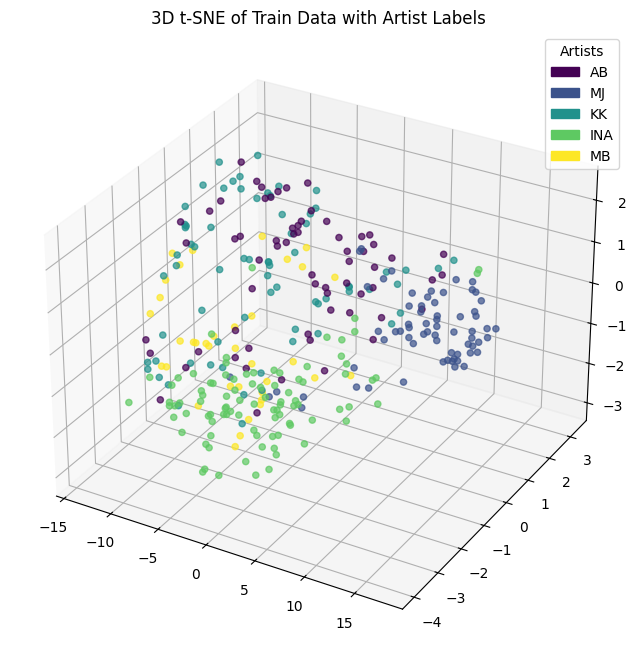

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

# Assuming `artist_short` is a list of short labels for each artist class
artist_short = ['AB', 'MJ', 'KK', 'INA', 'MB', 'ML']
unique_labels = np.unique(y_labels_train)

# Map each artist to a unique color
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

# Extract features from the train set and concatenate
train_features = []
train_labels = []

# Assuming your train data is in a DataLoader
for data, target in train_dataloader:
    data = data.to(device)
    features = model(data, extract_features=True)
    train_features.append(features.cpu().detach().numpy())
    train_labels.append(target.cpu().detach().numpy())

train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

# Apply t-SNE to reduce to 3D
tsne = TSNE(n_components=3, random_state=42)
train_features_3d = tsne.fit_transform(train_features)

# Visualize using 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each artist category with a specific color
for idx, label in enumerate(unique_labels):
    idx_points = np.where(train_labels == label)
    ax.scatter(train_features_3d[idx_points, 0], train_features_3d[idx_points, 1], train_features_3d[idx_points, 2],
               color=colors[idx], label=artist_short[label], s=20, alpha=0.7)

# Create legend with artist names
legend_handles = [mpatches.Patch(color=colors[i], label=artist_short[unique_labels[i]]) for i in range(len(unique_labels))]
plt.legend(handles=legend_handles, title="Artists", loc="upper right")

ax.set_title("3D t-SNE of Train Data with Artist Labels")
plt.show()


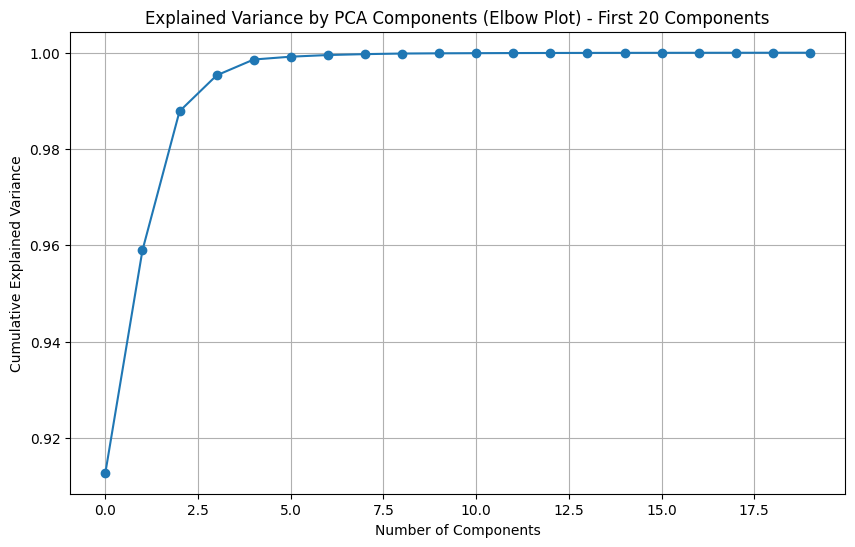

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA to reduce to a number of components (you can test with different numbers)
pca = PCA()
pca.fit(train_features)

# Get the explained variance for the first 20 components
explained_variance = pca.explained_variance_ratio_

# Limit to the first 20 components
explained_variance_20 = explained_variance[:20]

# Create an elbow plot for the first 20 components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_20), marker='o')
plt.title('Explained Variance by PCA Components (Elbow Plot) - First 20 Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


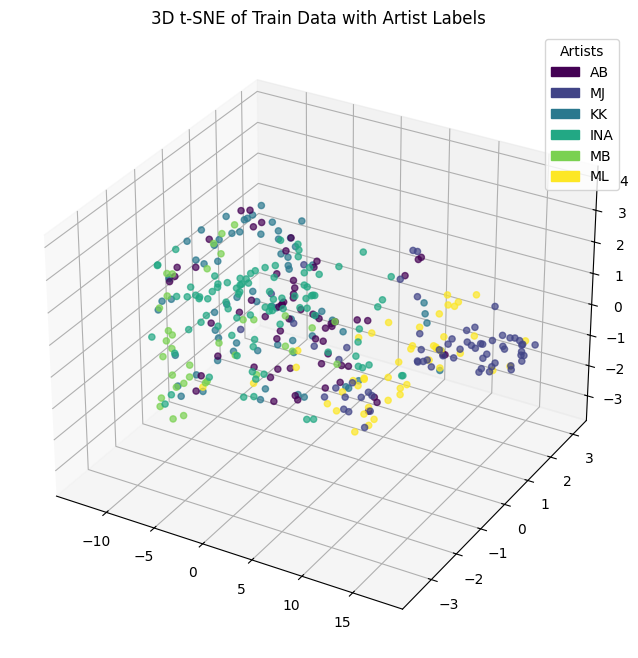

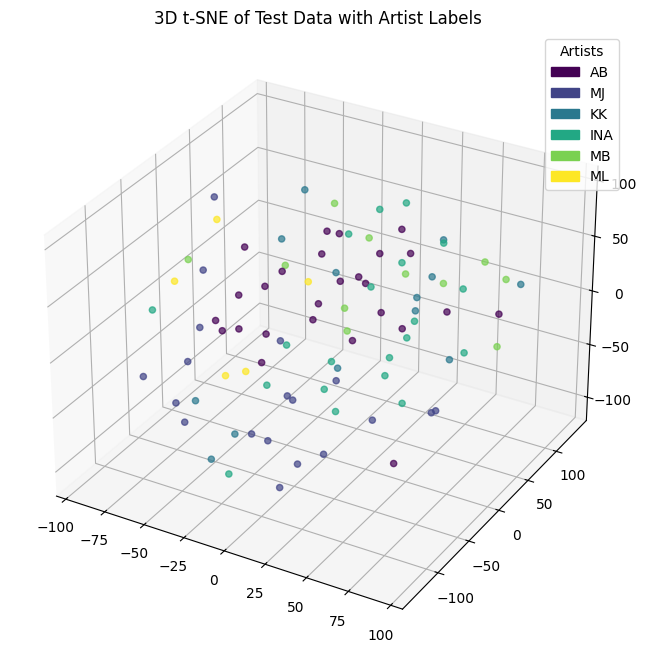

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

# Assuming `artist_short` is a list of short labels for each artist class
artist_short = ['AB', 'MJ', 'KK', 'INA', 'MB', 'ML']

# Color map for artists
def plot_tsne_3d(features, labels, title, artist_short):
    unique_labels = np.unique(labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42)
    features_3d = tsne.fit_transform(features)

    # Visualize using 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each artist category with a specific color
    for idx, label in enumerate(unique_labels):
        idx_points = np.where(labels == label)
        ax.scatter(features_3d[idx_points, 0], features_3d[idx_points, 1], features_3d[idx_points, 2],
                   color=colors[idx], label=artist_short[label], s=20, alpha=0.7)

    # Create legend with artist names
    legend_handles = [mpatches.Patch(color=colors[i], label=artist_short[unique_labels[i]]) for i in range(len(unique_labels))]
    plt.legend(handles=legend_handles, title="Artists", loc="upper right")

    ax.set_title(title)
    plt.show()

# Extract and process train features
train_features, train_labels = [], []
for data, target in train_dataloader:
    data = data.to(device)
    features = model(data, extract_features=True)
    train_features.append(features.cpu().detach().numpy())
    train_labels.append(target.cpu().detach().numpy())

train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

# Extract and process test features
test_features, test_labels = [], []
for data, target in test_dataloader:
    data = data.to(device)
    features = model(data, extract_features=True)
    test_features.append(features.cpu().detach().numpy())
    test_labels.append(target.cpu().detach().numpy())

test_features = np.concatenate(test_features, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Plot for train and test data
plot_tsne_3d(train_features, train_labels, "3D t-SNE of Train Data with Artist Labels", artist_short)
plot_tsne_3d(test_features, test_labels, "3D t-SNE of Test Data with Artist Labels", artist_short)


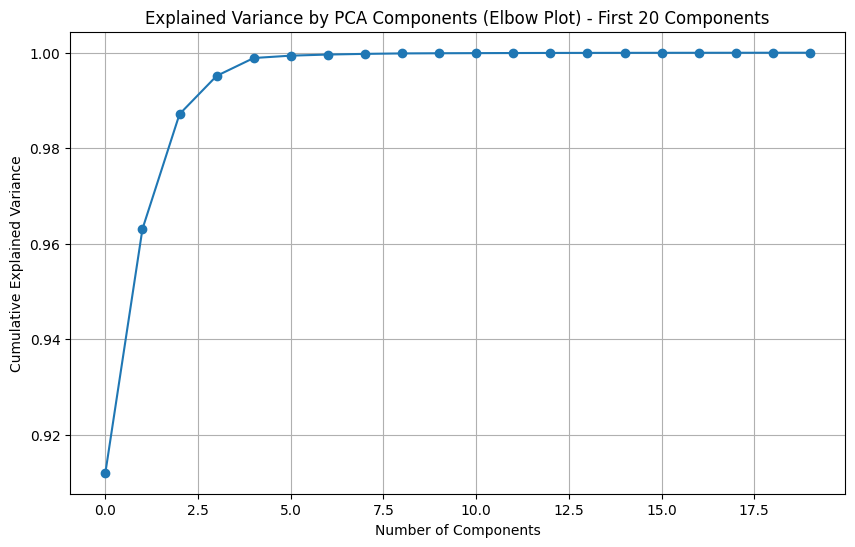

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA to reduce to a number of components (you can test with different numbers)
pca = PCA()
pca.fit(test_features)

# Get the explained variance for the first 20 components
explained_variance = pca.explained_variance_ratio_

# Limit to the first 20 components
explained_variance_20 = explained_variance[:20]

# Create an elbow plot for the first 20 components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_20), marker='o')
plt.title('Explained Variance by PCA Components (Elbow Plot) - First 20 Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()
